[simple_writes] big_spike lat: 0.180465 , big_spike starting time: 2020-06-11T18:38:46.309231-0500
[simple_writes] big_spike lat: 0.180443 , big_spike starting time: 2020-06-11T18:38:46.309302-0500
[simple_writes] big_spike lat: 0.180465 , big_spike starting time: 2020-06-11T18:38:46.309341-0500
[simple_writes] big_spike lat: 0.180406 , big_spike starting time: 2020-06-11T18:38:46.309415-0500
[simple_writes] big_spike lat: 0.180429 , big_spike starting time: 2020-06-11T18:38:46.309439-0500
[simple_writes] big_spike lat: 0.180354 , big_spike starting time: 2020-06-11T18:38:46.309535-0500
[simple_writes] big_spike lat: 0.180314 , big_spike starting time: 2020-06-11T18:38:46.309593-0500
[simple_writes] big_spike lat: 0.180313 , big_spike starting time: 2020-06-11T18:38:46.309609-0500
[simple_writes] big_spike lat: 0.180322 , big_spike starting time: 2020-06-11T18:38:46.309625-0500
[simple_writes] big_spike lat: 0.18029 , big_spike starting time: 2020-06-11T18:38:46.309678-0500
[simple_wri

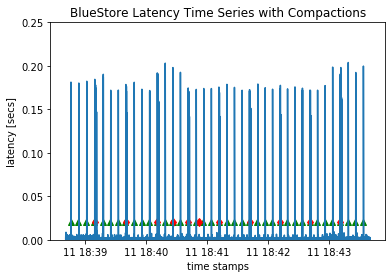

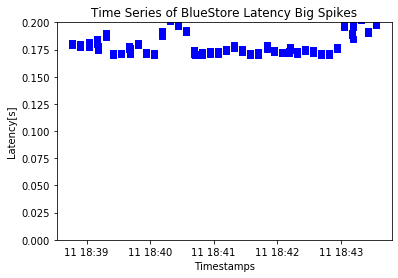

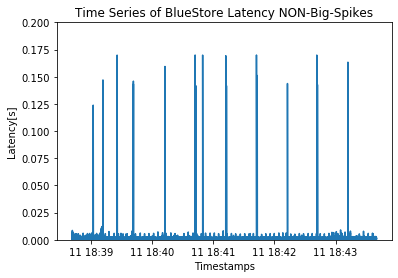

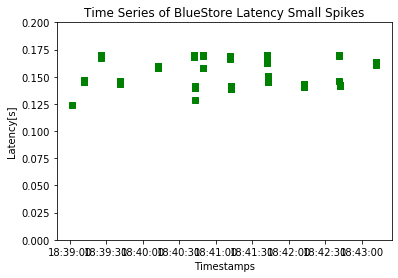

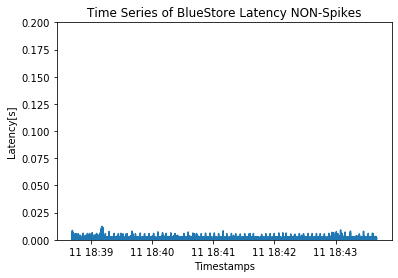

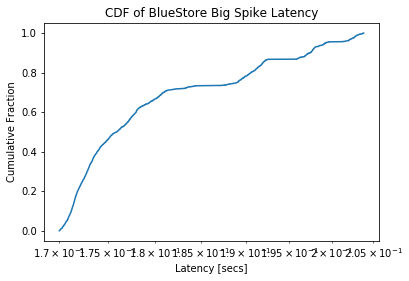

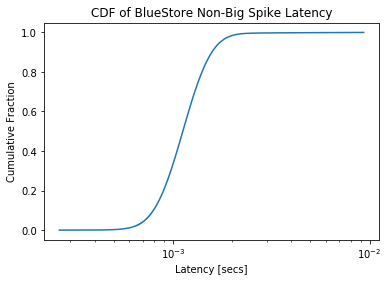

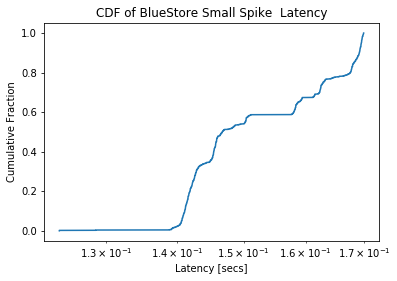

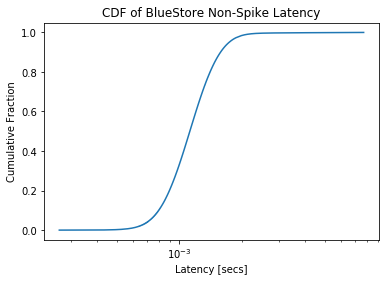

In [8]:
import sys
import numpy as np
from pandas import read_csv
import pandas as pd
from dateutil import parser
from datetime import datetime, timedelta, timezone
import pytz
import matplotlib.pyplot as plt

utc=pytz.UTC # work with offset-naive and offset-aware datetimes

# helper functions
def average(l): 
    return sum(l) / len(l)

f1='dump_time_stamps_vec.csv'
data1=read_csv(f1, skiprows=10000, parse_dates=True, squeeze=True, sep=',', header=None)
datalen = len(data1.values)

def check_bracket(str):
    if str == None:
        return "0"
    if str.startswith('['):
        return str[1:]
    if str.endswith(']'):
        return str[:-1]
    return str

# for bluestore latency(with compactions)
x_bs_lat = [] # bluestore starting timestamps(all)
y_bs_lat = [] # bluestore latencies(all)
# process spikes(timestamps)
big_spikes_ts = [] 
small_spikes_ts = []
non_big_spikes_ts = []
non_spikes_ts = []
# process spikes(latencies)
big_spikes_lat = []
small_spikes_lat = []
non_big_spikes_lat = []
non_spikes_lat = []

# process the time stamps
for i in range(datalen-1):
    # simple writes
    #if len(data1.values[i,:]) == len(data1.values[i+1,:]) and data1.values[i,2] == 'simple_s':
    if data1.values[i,2] == 'simple_s':
        # for first ctx
        ctr_ctx1 = parser.parse(check_bracket(data1.values[i,1])).replace(tzinfo=utc)
        simple_s1 = parser.parse(check_bracket(data1.values[i,3])).replace(tzinfo=utc)
        aio_done1 = parser.parse(check_bracket(data1.values[i,5])).replace(tzinfo=utc)
        flush_cmt_s1 = parser.parse(check_bracket(data1.values[i,7])).replace(tzinfo=utc)
        flush_cmt_e1 = parser.parse(check_bracket(data1.values[i,9])).replace(tzinfo=utc)
        simple_e1 = parser.parse(check_bracket(data1.values[i,11])).replace(tzinfo=utc)
        # for second ctx
        '''ctr_ctx2 = parser.parse(check_bracket(data1.values[i+1,1]))
        simple_s2 = parser.parse(check_bracket(data1.values[i+1,3]))
        aio_done2 = parser.parse(check_bracket(data1.values[i+1,5]))
        flush_cmt_s2 = parser.parse(check_bracket(data1.values[i+1,7]))
        flush_cmt_e2 = parser.parse(check_bracket(data1.values[i+1,9]))
        simple_e2 = parser.parse(check_bracket(data1.values[i+1,11]))'''
        
        # sanity check of timestamps
        if simple_s1 < ctr_ctx1 or aio_done1 < simple_s1 or flush_cmt_s1 < aio_done1 or flush_cmt_e1 < flush_cmt_s1 or simple_e1 < flush_cmt_e1:
            print("simple writes timestamp order is incorrect")
        
        # bluestore latency(including compactions)
        bluestore_lat_simple = simple_e1 - simple_s1
        x_bs_lat.append(simple_s1)
        y_bs_lat.append(bluestore_lat_simple.total_seconds())
        
        # separate spikes with NON-spikes
        if bluestore_lat_simple.total_seconds() > 0.17:
            print("[simple_writes] big_spike lat:",bluestore_lat_simple.total_seconds(),", big_spike starting time:",check_bracket(data1.values[i,3]))
            big_spikes_ts.append(simple_s1)
            big_spikes_lat.append(bluestore_lat_simple.total_seconds())
        if bluestore_lat_simple.total_seconds() <= 0.17:
            non_big_spikes_ts.append(simple_s1)
            non_big_spikes_lat.append(bluestore_lat_simple.total_seconds())
        if bluestore_lat_simple.total_seconds() > 0.025 and bluestore_lat_simple.total_seconds() <= 0.17:
            print("[simple_writes] small_spike lat:",bluestore_lat_simple.total_seconds(),", small_spike starting time:",check_bracket(data1.values[i,3]))
            small_spikes_ts.append(simple_s1)
            small_spikes_lat.append(bluestore_lat_simple.total_seconds())
        if bluestore_lat_simple.total_seconds() <= 0.025:
            non_spikes_ts.append(simple_s1)
            non_spikes_lat.append(bluestore_lat_simple.total_seconds())
            
    # deferred writes
    elif data1.values[i,2] == 'deferred_s':
        ctr_ctx1 = parser.parse(check_bracket(data1.values[i,1])).replace(tzinfo=utc)
        deferred_s1 = parser.parse(check_bracket(data1.values[i,3])).replace(tzinfo=utc)
        flush_cmt_s1 = parser.parse(check_bracket(data1.values[i,5])).replace(tzinfo=utc)
        flush_cmt_e1 = parser.parse(check_bracket(data1.values[i,7])).replace(tzinfo=utc)
        deferred_e1 = parser.parse(check_bracket(data1.values[i,9])).replace(tzinfo=utc)
        # sanity check of timestamps
        if deferred_s1 < ctr_ctx1 or flush_cmt_s1 < deferred_s1 or flush_cmt_e1 < flush_cmt_s1 or deferred_e1 < flush_cmt_e1:
            print("deferred writes timestamp order is incorrect")
        # bluestore latency
        bluestore_lat_deferred = deferred_e1 - deferred_s1
        x_bs_lat.append(deferred_s1)
        y_bs_lat.append(bluestore_lat_deferred.total_seconds())
        
        # separate spikes with NON-spikes
        if bluestore_lat_deferred.total_seconds() > 0.04:
            print("[deferred_writes] big_spike lat:",bluestore_lat_simple.total_seconds(),", big_spike starting time:",check_bracket(data1.values[i,3]))
            big_spikes_ts.append(simple_s1)
            big_spikes_lat.append(bluestore_lat_simple.total_seconds())
        if bluestore_lat_deferred.total_seconds() <= 0.04:
            non_big_spikes_ts.append(simple_s1)
            non_big_spikes_lat.append(bluestore_lat_simple.total_seconds())
        if bluestore_lat_deferred.total_seconds() > 0.02 and bluestore_lat_simple.total_seconds() <= 0.04:
            print("[deferred_writes] small_spike lat:",bluestore_lat_simple.total_seconds(),", small_spike starting time:",check_bracket(data1.values[i,3]))
            small_spikes_ts.append(simple_s1)
            small_spikes_lat.append(bluestore_lat_simple.total_seconds())
        if bluestore_lat_deferred.total_seconds() <= 0.02:
            non_spikes_ts.append(simple_s1)
            non_spikes_lat.append(bluestore_lat_simple.total_seconds())
        



# read compaction data from RocksDB
if0='flush_job_timestamps.csv'     # Compaction for L0
if1='compact_job_timestamps.csv'   # Compaction for other levels
id0=read_csv(if0, parse_dates=True, squeeze=True, sep=',', header=None)
id1=read_csv(if1, parse_dates=True, squeeze=True, sep=',', header=None)

# L0
id0len = len(id0.values)
x_l0_timestamps = [] # flush(L0) timestamps
x_l0_timestamps_us = [] #timestamps in microseconds for L0
y_l0_dummy = [] # dummp y value for L0
dur_l0 = [] # durations(width of compaction) for l0

# >=L1
id1len = len(id1.values)
x_l1_timestamps = [] # flush(L1) timestamps
x_l1_timestamps_us = [] #timestamps in microseconds for L1
y_l1_dummy = [] # dummp y value for L1
dur_l1 = [] # durations(width of compaction) for l1

# L0 compaction timestamps and durations
for i in range(id0len):
    x_l0_timestamps.append((parser.parse(id0.values[i,1])-timedelta(hours=5)).replace(tzinfo=utc))
    dur_l0.append(id0.values[i,5]/1000000)
    y_l0_dummy.append(0.02)
    x_l0_timestamps_us.append(id0.values[i,3])
# >=L1 compaction timestamps and durations
for i in range(id1len):
    x_l1_timestamps.append((parser.parse(id1.values[i,1])-timedelta(hours=5)).replace(tzinfo=utc))
    dur_l1.append(id1.values[i,5]/1000000)
    y_l1_dummy.append(0.02)
    x_l1_timestamps_us.append(id1.values[i,3])

avg_dur_l0 = 0 # average compaction duration for L0
avg_gap_l0 = 0 # average time interval between two compactions for L0
avg_dur_l1 = 0 # average compaction duration for >=L1
avg_gap_l1 = 0 # average time interval between two compactions for >=L1

# L0 avgs
for i in range(len(dur_l0)):
    avg_dur_l0 = avg_dur_l0 + dur_l0[i]
avg_dur_l0 = avg_dur_l0 / len(dur_l0)
for i in range(len(x_l0_timestamps_us)-1):
    avg_gap_l0 = avg_gap_l0 + x_l0_timestamps_us[i+1] - x_l0_timestamps_us[i] - dur_l0[i]
avg_gap_l0 = avg_gap_l0 / (len(x_l0_timestamps_us)-1)
# >=L1 avgs
for i in range(len(dur_l1)):
    avg_dur_l1 = avg_dur_l1 + dur_l1[i]
avg_dur_l1 = avg_dur_l1 / len(dur_l1)
for i in range(len(x_l1_timestamps_us)-1):
    avg_gap_l1 = avg_gap_l1 + x_l1_timestamps_us[i+1] - x_l1_timestamps_us[i] - dur_l1[i]
avg_gap_l1 = avg_gap_l1 / (len(x_l1_timestamps_us)-1)

print("L0 average compaction duration[secs]:",avg_dur_l0)
print("L1 average compaction duration[secs]:",avg_dur_l1)
print("L0 average time interval between two compactions[secs]:",avg_gap_l0/1000000)
print("L1 average time interval between two compactions[secs]:",avg_gap_l1/1000000)    
    
    
# write timestamps to files             
tmpf1=open('bs_big_spikes_ts.txt','w')
for ele in big_spikes_ts:
    tmpf1.write(ele.strftime("%Y-%m-%d %H:%M:%S.%f")+'\n')
tmpf1.close()
tmpf2=open('bs_non_big_spikes_ts.txt','w')
for ele in non_big_spikes_ts:
    tmpf2.write(ele.strftime("%Y-%m-%d %H:%M:%S.%f")+'\n')
tmpf2.close()
tmpf3=open('bs_small_spikes_ts.txt','w')
for ele in small_spikes_ts:
    tmpf3.write(ele.strftime("%Y-%m-%d %H:%M:%S.%f")+'\n')
tmpf3.close()
tmpf4=open('bs_non_spikes_ts.txt','w')
for ele in non_spikes_ts:
    tmpf4.write(ele.strftime("%Y-%m-%d %H:%M:%S.%f")+'\n')
tmpf4.close()

    
# plot both blustore latency and compacion
p0 = plt.figure()
ax0 = p0.add_subplot(111)
ax0.set_ylim(0,0.25)
ax0.plot(x_l0_timestamps, y_l0_dummy, label='L0 compaction',marker='^', c='g', linestyle='')
ax0.plot(x_l1_timestamps, y_l1_dummy, label='>=L1 compaction',marker='d', c='r', linestyle='')
ax0.plot(x_bs_lat, y_bs_lat, label='bluestore')
ax0.set(xlabel='time stamps', ylabel='latency [secs]', title='BlueStore Latency Time Series with Compactions')


# plot time series of big spikes
p11 = plt.figure() # big spikes
ax11 = p11.add_subplot(111)
ax11.set_ylim(0,0.2)
ax11.plot(big_spikes_ts, big_spikes_lat, label='big spikes', marker='s', c='b', linestyle='')
ax11.set(xlabel='Timestamps', ylabel='Latency[s]', title='Time Series of BlueStore Latency Big Spikes')
print("avg big-spike bluestore latency[secs]:",average(big_spikes_lat))
# plot time series of NON-big-spikes
p12 = plt.figure() # NON-big-spikes
ax12 = p12.add_subplot(111)
ax12.set_ylim(0,0.2)
ax12.plot(non_big_spikes_ts, non_big_spikes_lat, label='NON-big spikes')
ax12.set(xlabel='Timestamps', ylabel='Latency[s]', title='Time Series of BlueStore Latency NON-Big-Spikes')
print("avg non-big-spike bluestore latency[secs]:",average(non_big_spikes_lat))
# plot time series of small spikes
p21 = plt.figure() # small spikes
ax21 = p21.add_subplot(111)
ax21.set_ylim(0,0.2)
ax21.plot(small_spikes_ts, small_spikes_lat, label='small spikes', marker='s', c='g', linestyle='')
ax21.set(xlabel='Timestamps', ylabel='Latency[s]', title='Time Series of BlueStore Latency Small Spikes')
print("avg small-spike bluestore latency[secs]:",average(small_spikes_lat))
# plot time series of NON-spikes
p22 = plt.figure() # NON-spikes
ax22 = p22.add_subplot(111)
ax22.set_ylim(0,0.2)
ax22.plot(non_spikes_ts, non_spikes_lat, label='NON-spikes')
ax22.set(xlabel='Timestamps', ylabel='Latency[s]', title='Time Series of BlueStore Latency NON-Spikes')
print("avg non-spike bluestore latency[secs]:",average(non_spikes_lat))
tmpf5=open('bs_non_spikes_lat.txt','w')
for ele in non_spikes_lat:
    tmpf5.write(str(ele)+'\n')
tmpf5.close()

# distributions
big_spikes_lat.sort() # big spikes distribution
non_big_spikes_lat.sort() # non-big-spikes distribution
small_spikes_lat.sort() # small spikes distribution
non_spikes_lat.sort() # non-spikes distribution

x_big_spike_cdf = [] # latency of big spikes, x-axis
y_big_spike_cdf = [] # percentage of big spikes, y-axis
x_non_big_spike_cdf = [] # latency of non big spikes, x-axis
y_non_big_spike_cdf = [] # percentage of non big spikes, y-axis
x_small_spike_cdf = [] # latency of samll spikes, x-axis
y_small_spike_cdf = [] # percentage of small spikes, y-axis
x_non_spike_cdf = [] # latency of non spikes, x-axis
y_non_spike_cdf = [] # percentage of non spikes, y-axis

if len(big_spikes_lat) != 0:
    for i in range(0, 10000, 2):
        x_big_spike_cdf.append(big_spikes_lat[int(i/10000. * len(big_spikes_lat))])
        y_big_spike_cdf.append(i/10000.)        
if len(non_big_spikes_lat) != 0:
    for i in range(0, 10000, 2):
        x_non_big_spike_cdf.append(non_big_spikes_lat[int(i/10000. * len(non_big_spikes_lat))])
        y_non_big_spike_cdf.append(i/10000.)
if len(small_spikes_lat) != 0:
    for i in range(0, 10000, 2):
        x_small_spike_cdf.append(small_spikes_lat[int(i/10000. * len(small_spikes_lat))])
        y_small_spike_cdf.append(i/10000.)        
if len(non_spikes_lat) != 0:
    for i in range(0, 10000, 2):
        x_non_spike_cdf.append(non_spikes_lat[int(i/10000. * len(non_spikes_lat))])
        y_non_spike_cdf.append(i/10000.)
        
# plot distributions
p31 = plt.figure()
ax31 = p31.add_subplot(111)
ax31.set_xscale('log')
ax31.plot(x_big_spike_cdf, y_big_spike_cdf, label='cdf of bluestore big spikes')
ax31.set(xlabel='Latency [secs]', ylabel='Cumulative Fraction', title='CDF of BlueStore Big Spike Latency')
p32 = plt.figure()
ax32 = p32.add_subplot(111)
ax32.set_xscale('log')
ax32.plot(x_non_big_spike_cdf, y_non_big_spike_cdf, label='cdf of bluestore non-big spikes')
ax32.set(xlabel='Latency [secs]', ylabel='Cumulative Fraction', title='CDF of BlueStore Non-Big Spike Latency')
p41 = plt.figure()
ax41 = p41.add_subplot(111)
ax41.set_xscale('log')
ax41.plot(x_small_spike_cdf, y_small_spike_cdf, label='cdf of bluestore small spikes')
ax41.set(xlabel='Latency [secs]', ylabel='Cumulative Fraction', title='CDF of BlueStore Small Spike  Latency')
p42 = plt.figure()
ax42 = p42.add_subplot(111)
ax42.set_xscale('log')
ax42.plot(x_non_spike_cdf, y_non_spike_cdf, label='cdf of bluestore non-spikes')
ax42.set(xlabel='Latency [secs]', ylabel='Cumulative Fraction', title='CDF of BlueStore Non-Spike Latency')

plt.show()
plt.close()

Now we separate the comapctions with bluestore latencies. 

In [9]:
# read big spikes timestamps
f_big_spikes=open('bs_big_spikes_ts.txt','r')
l_big_spikes = f_big_spikes.read().split('\n')
del l_big_spikes[-1] # last element is "\n"
len_big_spikes = len(l_big_spikes)
num_of_txc_during_a_spike = 0
txc_during_a_spike_list01 = [] # number of txcs in a spike
for i in range(len_big_spikes-1):
    if (parser.parse(l_big_spikes[i+1]) - parser.parse(l_big_spikes[i])).total_seconds() > 0.01:
        txc_during_a_spike_list01.append(num_of_txc_during_a_spike) 
        num_of_txc_during_a_spike = 0 # reset the counter
    else:
        num_of_txc_during_a_spike = num_of_txc_during_a_spike + 1 # plus 1        
print("[big_spikes]","num_of_txc during a spike:",txc_during_a_spike_list01)        
f_big_spikes.close()


# read small spikes timestamps
f_small_spikes=open('bs_small_spikes_ts.txt','r')
l_small_spikes = f_small_spikes.read().split('\n')
del l_small_spikes[-1] # last element is "\n"
len_small_spikes = len(l_small_spikes)
num_of_txc_during_a_spike = 0
txc_during_a_spike_list02 = [] # number of txcs in a spike

for i in range(len_small_spikes-1):
    if (parser.parse(l_small_spikes[i+1]) - parser.parse(l_small_spikes[i])).total_seconds() > 0.01:
        txc_during_a_spike_list02.append(num_of_txc_during_a_spike) 
        num_of_txc_during_a_spike = 0 # reset the counter
    else:
        num_of_txc_during_a_spike = num_of_txc_during_a_spike + 1 # plus 1   
        
print("[small_spikes]","num_of_txc during a spike:",txc_during_a_spike_list02)
f_small_spikes.close()


# read non-big spikes timestamps
f_non_big_spikes=open('bs_non_big_spikes_ts.txt','r')
l_non_big_spikes = f_non_big_spikes.read().split('\n')
del l_non_big_spikes[-1] # last element is "\n"
len_non_big_spikes = len(l_non_big_spikes)
num_of_txc_during_2_spikes = 0
txc_during_2_spikes_list03 = [] # number of txcs between 2 spikes
for i in range(len_non_big_spikes-1):
    if (parser.parse(l_non_big_spikes[i+1]) - parser.parse(l_non_big_spikes[i])).total_seconds() > 0.1:
        txc_during_2_spikes_list03.append(num_of_txc_during_2_spikes) 
        num_of_txc_during_2_spikes = 0 # reset the counter
    else:
        num_of_txc_during_2_spikes = num_of_txc_during_2_spikes + 1 # plus 1        
print("[non_big_spikes]","num_of_txc during 2 spikes:",txc_during_2_spikes_list03)        
f_non_big_spikes.close()


# read non-spikes timestamps
f_non_spikes=open('bs_non_spikes_ts.txt','r')
l_non_spikes = f_non_spikes.read().split('\n')
del l_non_spikes[-1] # last element is "\n"
len_non_spikes = len(l_non_spikes)
num_of_txc_during_2_spikes = 0
txc_during_2_spikes_list04 = [] # number of txcs between 2 spikes
'''
num_of_txc_between_L0s = 0
txc_between_L0s = []
num_of_txc_between_L1s = 0
txc_between_L1s = []
idx_of_l0_list = 0
idx_of_l1_list = 0
'''
for i in range(len_non_spikes-1):
    if (parser.parse(l_non_spikes[i+1]) - parser.parse(l_non_spikes[i])).total_seconds() > 0.01:
        txc_during_2_spikes_list04.append(num_of_txc_during_2_spikes) 
        num_of_txc_during_2_spikes = 0 # reset the counter
    else:
        num_of_txc_during_2_spikes = num_of_txc_during_2_spikes + 1 # plus 1 
    '''
    #L0
    if idx_of_l0_list < len(x_l0_timestamps):
        if parser.parse(l_non_spikes[i][0:27]).replace(tzinfo=utc) < x_l0_timestamps[idx_of_l0_list]:
            num_of_txc_between_L0s += 1
        else:
            idx_of_l0_list += 1
            txc_between_L0s.append(num_of_txc_between_L0s)
            num_of_txc_between_L0s = 0  
    #L1
    if idx_of_l1_list < len(x_l1_timestamps):
        if parser.parse(l_non_spikes[i][0:27]).replace(tzinfo=utc) < x_l1_timestamps[idx_of_l1_list]:
            num_of_txc_between_L1s += 1
        else:
            idx_of_l1_list += 1
            txc_between_L1s.append(num_of_txc_between_L1s)
            num_of_txc_between_L1s = 0
    '''
print("[non_spikes]","num_of_txc during 2 spikes:",txc_during_2_spikes_list04)  
#print("# of txcs between two L0 compactions:",txc_between_L0s) 
#print("# of txcs between two L1 compactions:",txc_between_L1s) 
f_non_spikes.close()

def average(l): 
    return sum(l) / len(l) 

print("avg # of txcs in a big spike:", average(txc_during_a_spike_list01))
print("avg # of txcs in a small spike:", average(txc_during_a_spike_list02))
print("avg # of txcs between 2 big spikes:", average(txc_during_2_spikes_list03))
print("avg # of txcs between 2 small spikes:", average(txc_during_2_spikes_list04))
#print("avg # of txcs between 2 small spikes of L0:", average(txc_between_L0s))
#print("avg # of txcs between 2 small spikes of L1:", average(txc_between_L1s))


[big_spikes] num_of_txc during a spike: [47, 47, 46, 47, 47, 47, 32, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 18, 40, 47, 47, 47, 47, 47, 47, 47, 10, 47, 47, 47, 47, 47, 47, 47, 47, 47, 40, 47, 47, 47, 47, 46, 0, 47, 47]
[small_spikes] num_of_txc during a spike: [0, 47, 14, 47, 47, 28, 46, 0, 4, 1, 47, 47, 36, 47, 47, 5, 0, 47]
[non_big_spikes] num_of_txc during 2 spikes: [74416, 126681, 126014, 126471, 5681, 10246, 109792, 125116, 126660, 125634, 4704, 6022, 115625, 124178, 127373, 125958, 5583, 9176, 110098, 126473, 126109, 125737, 6064, 7757, 111788, 126296, 125157, 125680, 5186, 7874, 113218, 124793, 126448, 125766, 3752, 5937, 115988, 125472, 125585, 125612, 5530, 9213, 110807, 125607, 125586, 125819, 5594, 8279, 111401, 126080, 125347, 125321, 5542, 8007, 112428, 126347, 125705]
[non_spikes] num_of_txc during 2 spikes: [74416, 126681, 126013, 126471, 5681, 10198, 109792, 125101, 126660, 125634, 4704, 5974, 115625, 124178, 127373, 125958, 5583, 9128, 110098, 126473, 126109,

[Text(0, 0.5, 'latency [secs]'),
 Text(0.5, 0, 'time stamps'),
 Text(0.5, 1.0, 'BlueStore Latency Time Series with Compactions')]

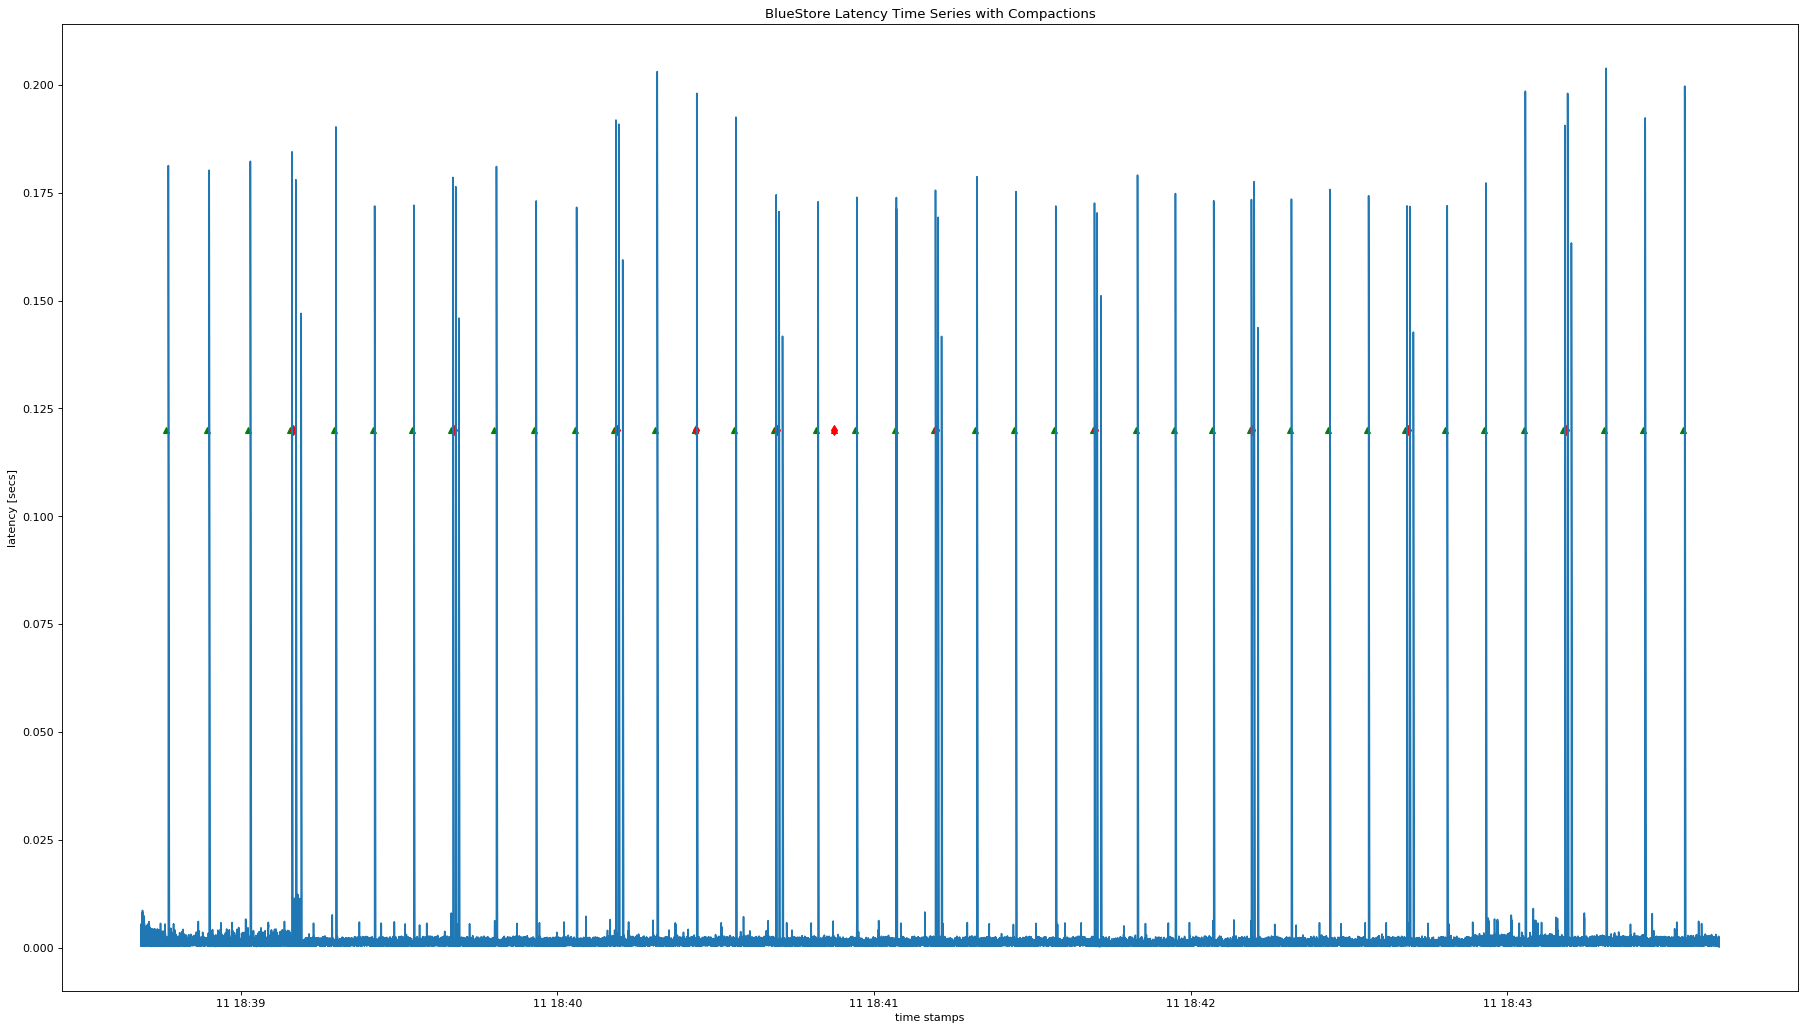

In [10]:
# plot both blustore latency and compacion
p0 = plt.figure(figsize=(28, 16), dpi= 80, facecolor='w', edgecolor='k')
ax0 = p0.add_subplot(111)
#ax0.set_ylim(0,0.25)
new_y_l0_dummy = [i * 6 for i in y_l0_dummy]
new_y_l1_dummy = [i * 6 for i in y_l1_dummy]
ax0.plot(x_l0_timestamps, new_y_l0_dummy, label='L0 compaction',marker='^', c='g', linestyle='')
ax0.plot(x_l1_timestamps, new_y_l1_dummy, label='>=L1 compaction',marker='d', c='r', linestyle='')
ax0.plot(x_bs_lat, y_bs_lat, label='bluestore')
ax0.set(xlabel='time stamps', ylabel='latency [secs]', title='BlueStore Latency Time Series with Compactions')

In [11]:
print("avg # of txcs between 2 small spikes:", average(txc_during_2_spikes_list04))

avg # of txcs between 2 small spikes: 85160.64912280702
